In [1]:
import random
import time

import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.autograd import Variable
from torch.utils.data.sampler import SubsetRandomSampler
from torchvision import datasets, transforms

In [2]:
def data_loaders(root, batch_size, valid_size=0.1, option='cifar10', cuda=False, random_seed=1113):
    # Prepare datasets
    kwargs = {'num_workers': 8, 'pin_memory': True} if torch.cuda.is_available() and cuda else {}

    if option == 'cifar10':
        # Load CIFAR10 dataset
        transform_train = transforms.Compose([transforms.RandomCrop(32, padding=4),
                                              transforms.RandomHorizontalFlip(),
                                              transforms.ToTensor(),
                                              transforms.Normalize((0.4914, 0.4822, 0.4465), (0.247, 0.243, 0.261)),
                                              Cutout(n_holes=1, length=16)
                                              ])

        transform_test = transforms.Compose([transforms.ToTensor(),
                                             transforms.Normalize((0.4914, 0.4822, 0.4465), (0.247, 0.243, 0.261))
                                             ])

        training_set = datasets.CIFAR10(root=root, train=True, download=True, transform=transform_train)
        validation_set = datasets.CIFAR10(root=root, train=True, transform=transform_test)
        test_set = datasets.CIFAR10(root=root, train=False, transform=transform_test)

        # classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

    elif option == 'mnist':
        # Load MNIST
        transform_train = transforms.Compose([transforms.ToTensor(),
                                              transforms.Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))
#                                               transforms.Normalize((0.1307,), (0.3081,))
                                              ])

        transform_test = transforms.Compose([transforms.ToTensor(),
                                             transforms.Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))
#                                              transforms.Normalize((0.1307,), (0.3081,))
                                             ])

        training_set = datasets.MNIST(root=root, train=True, download=True, transform=transform_train)
        validation_set = datasets.MNIST(root=root, train=True, transform=transform_test)
        test_set = datasets.MNIST(root=root, train=False, transform=transform_test)
        # classes = tuple(range(10))

    else:
        raise ValueError("Data option not supported.")

    full_train_loader = torch.utils.data.DataLoader(training_set, batch_size=batch_size, shuffle=True, **kwargs)
    test_loader = torch.utils.data.DataLoader(test_set, batch_size=batch_size, shuffle=True, **kwargs)

    return full_train_loader, test_loader

In [3]:
data_path = "data/"


train_loader, test_loader = data_loaders(root=data_path, batch_size=100, valid_size=0.3,
                                   option='mnist', cuda=True)

In [5]:
class Generator(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(100, 256)
        self.fc2 = nn.Linear(256, 512)
        self.fc3 = nn.Linear(512, 1024)
        self.fc4 = nn.Linear(1024, 784)
        
    def forward(self, x):
        x = self.fc1(x)
        x = F.leaky_relu(x, 0.2)
        x = self.fc2(x)
        x = F.leaky_relu(x, 0.2)
        x = self.fc3(x)
        x = F.leaky_relu(x, 0.2)
        x = self.fc4(x)
        x = F.tanh(x)
        
        return x
    
class Discriminator(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(784, 1024)
        self.fc2 = nn.Linear(1024, 512)
        self.fc3 = nn.Linear(512, 256)
        self.fc4 = nn.Linear(256, 1)
        
    def forward(self, x):
        x = self.fc1(x)
        x = F.leaky_relu(x, 0.2)
        x = F.dropout(x, 0.3)
        x = self.fc2(x)
        x = F.leaky_relu(x, 0.2)
        x = F.dropout(x, 0.3)
        x = self.fc3(x)
        x = F.leaky_relu(x, 0.2)
        x = F.dropout(x, 0.3)
        x = self.fc4(x)
        x = F.sigmoid(x)
        
        return x.view(x.size(0), -1)

In [9]:
criterion = nn.BCELoss()
lr = 0.0002

In [25]:
def train(generator, discriminator, data_loader, epochs=100, log_interval=10):
    if torch.cuda.is_available():
        generator = generator.cuda()
        discriminator = discriminator.cuda()
        
    g_optimizer = optim.Adam(generator.parameters(), lr=lr)
    d_optimizer = optim.Adam(discriminator.parameters(), lr=lr / 10)
        
    for epoch in range(1, epochs + 1):
        for batch_idx, (data, _) in enumerate(train_loader, 1):
            if torch.cuda.is_available():
                data = data.cuda()
                
            batch_size = data.shape[0]
            
            z_input = torch.randn(batch_size, 100)
            
            if torch.cuda.is_available():
                z_input = z_input.cuda()
                
            g_output = generator(z_input)
        
            real_labels = torch.ones(batch_size)
            fake_labels = torch.zeros(batch_size)    
            
            if torch.cuda.is_available():
                real_labels = real_labels.cuda()
                fake_labels = fake_labels.cuda()

            d_optimizer.zero_grad()
            d_output_fake = discriminator(g_output)
            d_output_real = discriminator(data.view(-1, data.size(1) * data.size(2) * data.size(3)))
            
            fake_loss =  criterion(d_output_fake, fake_labels)
            real_loss = criterion(d_output_real, real_labels)
            
            d_loss = fake_loss + real_loss
            d_loss.backward(retain_graph=True)
            d_optimizer.step()
            
            g_optimizer.zero_grad()
            g_loss = criterion(d_output_fake, real_labels)
            g_loss.backward()
            g_optimizer.step()
                    
            if batch_idx % 100 == 0:
                print('Train Epoch: {} [Iter: {}]\t Gloss: {:.6f} Dloss: {:.6f}'.format(
                      epoch, batch_idx, g_loss.data.item(), d_loss.data.item()))
                    
                
        if not epoch % log_interval:
            images_torch = g_output.view(-1, 1, 28, 28)
            images = images_torch.cpu().detach().numpy()
            img = images[0]
            print(img.shape)
            img = np.rollaxis(img, 0, 3).squeeze(2)                       
            print(img.shape)
            plt.figure(figsize=(4, 4))
            plt.imshow(img, cmap='gray')
            plt.show()
        

In [26]:
g_model = Generator()
d_model = Discriminator()

/anaconda2/envs/pytorch/lib/python3.6/site-packages/torch/nn/functional.py:995: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
/anaconda2/envs/pytorch/lib/python3.6/site-packages/torch/nn/functional.py:1006: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/anaconda2/envs/pytorch/lib/python3.6/site-packages/torch/nn/functional.py:1594: UserWarning: Using a target size (torch.Size([100])) that is different to the input size (torch.Size([100, 1])) is deprecated. Please ensure they have the same size.
  "Please ensure they have the same size.".format(target.size(), input.size()))


Train Epoch: 1 [Iter: 100]	 Gloss: 2.055814 Dloss: 0.227065
Train Epoch: 1 [Iter: 200]	 Gloss: 1.006774 Dloss: 0.527398
Train Epoch: 1 [Iter: 300]	 Gloss: 1.318467 Dloss: 0.420081
Train Epoch: 1 [Iter: 400]	 Gloss: 1.793002 Dloss: 0.222515
Train Epoch: 1 [Iter: 500]	 Gloss: 3.418005 Dloss: 0.058249
Train Epoch: 1 [Iter: 600]	 Gloss: 3.161048 Dloss: 0.079999
Train Epoch: 2 [Iter: 100]	 Gloss: 3.102488 Dloss: 0.091298
Train Epoch: 2 [Iter: 200]	 Gloss: 5.376804 Dloss: 0.008862
Train Epoch: 2 [Iter: 300]	 Gloss: 5.709061 Dloss: 0.005479
Train Epoch: 2 [Iter: 400]	 Gloss: 2.867065 Dloss: 0.079802
Train Epoch: 2 [Iter: 500]	 Gloss: 6.597619 Dloss: 0.005034
Train Epoch: 2 [Iter: 600]	 Gloss: 7.198427 Dloss: 0.002518
Train Epoch: 3 [Iter: 100]	 Gloss: 7.674338 Dloss: 0.001335
Train Epoch: 3 [Iter: 200]	 Gloss: 7.982672 Dloss: 0.001078
Train Epoch: 3 [Iter: 300]	 Gloss: 8.266235 Dloss: 0.000787
Train Epoch: 3 [Iter: 400]	 Gloss: 8.446899 Dloss: 0.000607
Train Epoch: 3 [Iter: 500]	 Gloss: 8.607

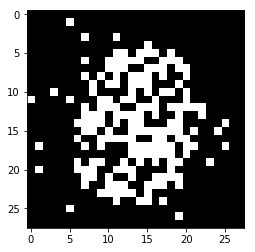

Train Epoch: 11 [Iter: 100]	 Gloss: 7.078351 Dloss: 0.005700
Train Epoch: 11 [Iter: 200]	 Gloss: 5.800197 Dloss: 0.003517
Train Epoch: 11 [Iter: 300]	 Gloss: 7.876993 Dloss: 0.000492
Train Epoch: 11 [Iter: 400]	 Gloss: 7.728708 Dloss: 0.003442
Train Epoch: 11 [Iter: 500]	 Gloss: 8.887798 Dloss: 0.000163
Train Epoch: 11 [Iter: 600]	 Gloss: 6.243179 Dloss: 0.003290
Train Epoch: 12 [Iter: 100]	 Gloss: 10.429129 Dloss: 0.000059
Train Epoch: 12 [Iter: 200]	 Gloss: 7.746459 Dloss: 0.000517
Train Epoch: 12 [Iter: 300]	 Gloss: 8.664832 Dloss: 0.000307
Train Epoch: 12 [Iter: 400]	 Gloss: 9.164437 Dloss: 0.000152
Train Epoch: 12 [Iter: 500]	 Gloss: 9.879733 Dloss: 0.000104
Train Epoch: 12 [Iter: 600]	 Gloss: 10.053699 Dloss: 0.000126
Train Epoch: 13 [Iter: 100]	 Gloss: 9.791146 Dloss: 0.000072
Train Epoch: 13 [Iter: 200]	 Gloss: 10.720203 Dloss: 0.000039
Train Epoch: 13 [Iter: 300]	 Gloss: 10.661018 Dloss: 0.000066
Train Epoch: 13 [Iter: 400]	 Gloss: 8.972901 Dloss: 0.000183
Train Epoch: 13 [Ite

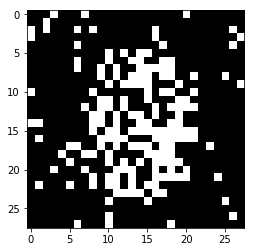

Train Epoch: 21 [Iter: 100]	 Gloss: 14.991366 Dloss: 0.000001
Train Epoch: 21 [Iter: 200]	 Gloss: 15.059561 Dloss: 0.000001
Train Epoch: 21 [Iter: 300]	 Gloss: 15.183512 Dloss: 0.000000
Train Epoch: 21 [Iter: 400]	 Gloss: 15.286868 Dloss: 0.000001
Train Epoch: 21 [Iter: 500]	 Gloss: 15.361685 Dloss: 0.000001
Train Epoch: 21 [Iter: 600]	 Gloss: 14.861195 Dloss: 0.000001
Train Epoch: 22 [Iter: 100]	 Gloss: 15.121793 Dloss: 0.000000
Train Epoch: 22 [Iter: 200]	 Gloss: 14.910320 Dloss: 0.000001
Train Epoch: 22 [Iter: 300]	 Gloss: 14.957775 Dloss: 0.000000
Train Epoch: 22 [Iter: 400]	 Gloss: 10.753169 Dloss: 0.000211
Train Epoch: 22 [Iter: 500]	 Gloss: 19.354639 Dloss: 0.000002
Train Epoch: 22 [Iter: 600]	 Gloss: 18.562376 Dloss: 0.000001
Train Epoch: 23 [Iter: 100]	 Gloss: 18.126472 Dloss: 0.000000
Train Epoch: 23 [Iter: 200]	 Gloss: 17.869846 Dloss: 0.000000
Train Epoch: 23 [Iter: 300]	 Gloss: 17.666872 Dloss: 0.000000
Train Epoch: 23 [Iter: 400]	 Gloss: 17.523317 Dloss: 0.000000
Train Ep

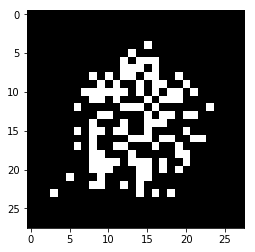

Train Epoch: 31 [Iter: 100]	 Gloss: 16.795523 Dloss: 0.000000
Train Epoch: 31 [Iter: 200]	 Gloss: 17.166512 Dloss: 0.000000
Train Epoch: 31 [Iter: 300]	 Gloss: 17.423182 Dloss: 0.000000
Train Epoch: 31 [Iter: 400]	 Gloss: 17.491484 Dloss: 0.000000
Train Epoch: 31 [Iter: 500]	 Gloss: 17.688023 Dloss: 0.000000
Train Epoch: 31 [Iter: 600]	 Gloss: 17.902464 Dloss: 0.000000
Train Epoch: 32 [Iter: 100]	 Gloss: 17.991585 Dloss: 0.000000
Train Epoch: 32 [Iter: 200]	 Gloss: 18.134035 Dloss: 0.000000
Train Epoch: 32 [Iter: 300]	 Gloss: 18.262941 Dloss: 0.000000
Train Epoch: 32 [Iter: 400]	 Gloss: 18.359348 Dloss: 0.000000
Train Epoch: 32 [Iter: 500]	 Gloss: 18.414549 Dloss: 0.000000
Train Epoch: 32 [Iter: 600]	 Gloss: 18.517790 Dloss: 0.000000
Train Epoch: 33 [Iter: 100]	 Gloss: 18.578817 Dloss: 0.000000


KeyboardInterrupt: 

In [27]:
# torch.cuda.set_device(1)
_ = train(g_model, d_model, train_loader)